# Coursework 2 - Neural Networks and Unsupervised Learning

__Name__: Georgios Alevras <br> __CID__: 01531221 <br> __Date__: 25/03/2022

<a name="outline"></a>

## Outline

- [Preliminaries](#preliminaries): Exploratory Data Analysis
- [Task 1](#task-1): Neural Networks
  - [1.1](#q11) Multi-Layer Perceptron (MLP)
  - [1.2](#q12) Convolutional Neural Network (CNN)
- [Task 2](#task-2): Unsupervised Learning
  - [2.1](#q21) Dimensionality Reduction and Clustering of a Subset of the Fashion-MNIST Image Data
  - [2.2](#q22) Clustering of the Feature Matrix
  - [2.3](#q23) Graph-Based Analysis
- [Task 3](#task-3): Mastery Component
  - [3.1](#q31) Non-Negative Matrix Factorization (NMF) for Dimensionality Reduction
  - [3.2](#q32) Community Detection

<a name="preliminaries"></a>
# Preliminaries: Exploratory Data Analysis [^](#outline)

Firstly, we import all the necessary Python packages to perform and execute all calculations and computations.

In [1]:
# All packages used in this coursework are imported here.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Warning sign appears because I use Ubuntu and I haven't installed NVIDIA drivers so my GPU is not used.
import os

2022-03-16 02:17:10.310765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 02:17:10.310782: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We then import the dataset (both train and test data) using the function provided below, and perform an initial inspection of it, printing the shapes of each (x_train, y_train, x_test, y_test).

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)  # convert labels to categorical samples
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return (x_train, y_train, x_test, y_test)

In [3]:
x_train, y_train, x_test, y_test = load_data()  # import the data
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000, 10)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000, 10)


We see that the training data consists of $60,000$ images of dimensions (pixels) $28$ by $28$ as our input data, and $60,000$ output vectors of size $10$, denoting the class output (what garment is depicted by each image, e.g., T-shirt, pullover, dress, etc.). Similarly, the test data consists of $10,000$ images of the same dimensions as in the train data, and $10,000$ output vectors of size $10$, again, denoting the class output. To inspect further how they look, we depict a few examples below in *Figure 1*.

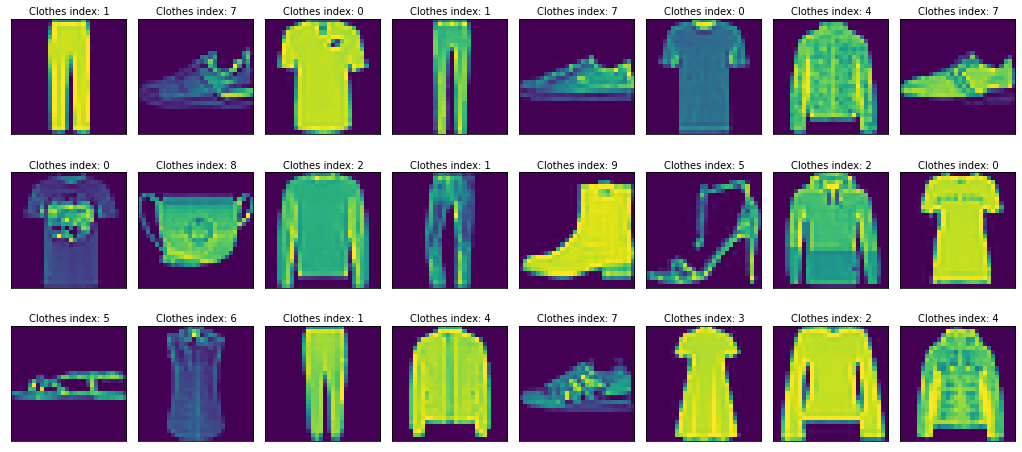

In [4]:
n_rows, n_cols = 3, 8
random_inx = np.random.choice(x_train.shape[0], n_rows * n_cols, replace=False)  # Selecting random data points from train data
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for n, i in enumerate(random_inx):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(x_train[i])  # Visualising image
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(4., -1.5, f'Clothes index: {np.argmax(y_train[i])}')  # Categorising output by index of output vector
plt.show()

**Figure 1:** A set of $24$ randomly selected images from the train dataset with their class category written above each image, denoted by the index of the output (category) vector it belongs to.

Finally, we can explore the class distribution of the data by obtaining the number of pictures that belong to each class, as shown below.

In [5]:
number_of_images_per_class_train = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}  # dictionary to hold occurence of each class (clothes type)
for i in range(len(y_train)):
    number_of_images_per_class_train[np.argmax(y_train[i])] += 1

number_of_images_per_class_test = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}  # dictionary to hold occurence of each class (clothes type)
for i in range(len(y_test)):
    number_of_images_per_class_test[np.argmax(y_test[i])] += 1

for i in range(len(number_of_images_per_class_train.keys())-1):  # loops through all classes to check they are all equivalent
    assert(number_of_images_per_class_train[i] == number_of_images_per_class_train[i+1])  # ensuring occurences of all classes are equivalent
    assert(number_of_images_per_class_test[i] == number_of_images_per_class_test[i+1])  # ensuring occurences of all classes are equivalent

print('Number of each category of clothes (train):', number_of_images_per_class_train)
print('Number of each category of clothes (test):', number_of_images_per_class_test)

Number of each category of clothes (train): {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
Number of each category of clothes (test): {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


We can see that the two datasets are well-balanced, with an equal number of items belonging to each class both for our train and our test data, as was also verified from all assertions returning True. As a result of the dataset being well-balanced, we expect a baseline accuracy of 10% (1 over the number of classes), thus, if the MLP obtains an accuracy less than 10% the model would perform worse than picking at random, while any accuracy above 10% demonstrates that the MLP has at least some predictive power. Next, we build our Multi-Layer Perceptron.

<a name="task-1"></a>
# Task 1: Neural Networks [^](#outline)

<a name="q11"></a>

## 1.1 Multi-Layer Perceptron (MLP) [^](#outline)

<a name="q111"></a>

#### 1.1.0.a Structure of MLP [^](#outline)

The Multi-Layer Perceptron (MLP) is a specific kind of feed-forward Artificial Neural Network (ANN) which consists of an input layer, an output layer and some number $L \in \mathbb{Z}^+$ of hidden layers, all of which are dense / fully-connected (all nodes in one layer are connected to all other nodes in the next layer). The MLP consists of the composition of many affine transformations, followed by the application of non-linear activation functions which operate element-wise. The architecture of the network can be fully described by the following equations:
$$\mathbf{h}^{(0)}:=\mathbf{x},$$
$$\mathbf{h}^{(k)}=\sigma \left( \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \right), \quad k=1, \dots, L,$$
$$\mathbf{\hat{y}} = \sigma_\text{out}\left( \mathbf{w}^{(L)} + \mathbf{b}^{(L)} \right),$$

where $\mathbf{x} \in \mathbb{R}^D$ is an example input, $\mathbf{W}^{(k)} \in \mathbb{R}^{n_{k+1} \times n_k}$ is the matrix holding the weights between nodes of layer $n_k$ and $n_{k+1}$, $\mathbf{b}^{(k)} \in \mathbb{R}^{n_{k+1}}$ is the vector of biases added to the pre-activations $\mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)}$ at layer $k$, $\mathbf{h}^{(k)} \in \mathbb{R}^{n_{k}}$ is the vector of post-activation (or activation) values at layer $k$, $n_0 := D$, and $n_k$ is the number of nodes (neurons) at the $k$-th hidden layer. The activation function applied to the pre-activation values is $\sigma:\mathbb{R} \rightarrow \mathbb{R}$, while the activation function applied to the output values is $\sigma_\text{out}:\mathbb{R} \rightarrow \mathbb{R}$.

<a name="q112"></a>

#### 1.1.0.b Error Backpropagation [^](#outline)

Using the set of equations described above we can perform a forward pass on a data-point (or a set of data-points) to predict its output. However, initially, all the weights and biases are random - the MLP has not been trained. Therefore, we want to learn the model to make good predictions. We achieve this via ***error backpropagation*** through:
1. the computation of the *stochastic gradient of the loss function* with respect to the parameters (weights and biases) of the MLP
2. the update of the MLP parameters using the already-computed gradients

Once we have computed all gradients for all model parameters we can update them according to *stochastic gradient descent* as such:

$$\theta_{t+1}=\theta_t - \eta\nabla_t L(\theta_t;D_m), \quad t \in \mathbb{N}_0,$$

for each iteration $t$, where $\eta$ is the *learning rate* and the loss value $L$ is evaluated using a randomly sampled subset of the training data $\mathcal{D}_m$ called a ***batch***, where $|\mathcal{D}_m| \ll |\mathcal{D}_\text{train}|$. The loss value $L$ is the average loss value from all data-points in a batch $\mathcal{D}_m$:

$$L(\theta_t; \mathcal{D}_m)=\frac{1}{M}\sum_{x_i, y_i \in \mathcal{D}_m} l(y_i, f_{\theta_t}(x_i)),$$

where $f_{\theta_t}(x_i)$ is the MLP model, and $L_i := l(y_i, f_{\theta_t}(x_i))$ is the per-example (data-point) loss. Therefore, our goal is to compute all gradients (using the chain rule):

$$\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}\frac{\partial{a_p^{(k+1)}}}{\partial{w_{pq}^{(k)}}},$$
$$\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}\frac{\partial{a_p^{(k+1)}}}{\partial{b_p^{(k)}}},$$

where $\mathbf{a}^{(k)}=\mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)}$ are the pre-activation values, which enable us to simplify the above equations as:

$$\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}h_q^{(k)} =: \delta_p^{(k+1)}h_q^{(k)},$$
$$\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}} =: \delta_p^{(k+1)},$$

where $\delta_p^{(k)} := \frac{\partial{L_i}}{\partial{a_p^{(k)}}}$. Next, we have to evaluate $\delta_p^{(k)}$:
$$\delta_p^{(k)}= \frac{\partial{L_i}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \frac{\partial{L_i}}{\partial{a_j^{(k+1)}}} \frac{\partial{a_j^{(k+1)}}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \delta_j^{(k+1)} \frac{\partial{a_j^{k+1}}}{\partial{a_p^{(k)}}}.$$

Knowing that: $a_j^{k+1}=\sum_{l=1}^{n_k} w_{jl}^{(k)}\sigma(a_l^{(k)}) + b_p^{(k)}$, we get: $\frac{\partial{a_j^{(k+1)}}}{\partial{a_p^{(k)}}}=w_{jp}^{(k)}\sigma'(a_p^{(k)})$, which means that:

$$\delta_p^k=\frac{\partial{L_i}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \delta_p^{(k+1)} \frac{\partial{a_j^{k+1}}}{\partial{a_p^{(k)}}}=\sigma'(a_p^{(k)}) \sum_{j=1}^{n_{k+1}} w_{jp}^{(k)}\delta_p^{(k+1)} = \sigma'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T \delta^{(k+1)},$$

where $\sigma'(\mathbf{a}^{(k)})=\text{diag}([\sigma'(a_p^{(k)})]_{p=1}^{n_k}).$ 

Therefore, in order for the MLP to learn, we need to:

1. Perform a forward pass of a batch of data-points through the MLP, computing and storing all pre-activations $\mathbf{a}^{(k)}$ and post-activations $\mathbf{h}^{(k)}$
2. Evaluate the errors on the output layer, $\delta^{(L+1)}=\frac{\partial{L_i}}{\partial{\mathbf{a}^{L+1}}}$
3. Backpropagate the errors for each layer using $\delta^{(k)}=\sigma'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T \delta^{(k+1)}$
4. Use the errors to obtain the derivaties of the per-example loss values: $\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\delta_p^{(k+1)}h_q^{(k)}$, $\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\delta_p^{(k+1)}$
5. Update the MLP parameters using stochastic gradient descent: $\theta_{t+1}=\theta_t - \eta\nabla_t L(\theta_t;D_m)$

<a name="q113"></a>

#### 1.1.0.c Architecture of MLP for this Task [^](#outline)

For this particular task we need to choose the architecture of the model; the number of hidden layers $L$, the number of nodes (neurons) in each layer (including the input and the output layers), the activation function $\sigma$, and the output activation function $\sigma_\text{out}$. Given the nature of our dataset, printed above, we naturally define the input layer to have $784 = 28 \times 28$ neurons, i.e., we flatten the 2D array of pixels for an image to get a 1D array which we define as $\mathbf{h}^0:=\mathbf{x}$, and we define our output layer to have $10$ neurons, one for each class. We then decide to have $5$ hidden layers, each with $400$ neurons, and use $\text{LeakyReLU}(x)$ as the activation function for all layers except the output layer, for which we use the softmax function:

$$\text{LeakyReLU}(x)=\begin{cases} x, \quad x>0\\ \alpha x, \:\:\:x<=0\end{cases},$$

where $\alpha$ is a constant (in this case $\alpha=0.01$), and

$$\hat{\mathbf{y}}_j:=\text{softmax}(\mathbf{a}^{(L+1)})_j=\frac{\text{exp}(a_j)}{\sum_i \text{exp}(a_i)},$$

where $\mathbf{a}^{(L+1)}$ are the pre-activation values at the output layer, and $\hat{\mathbf{y}}$ is the vector of predicted probabilities for each class for a data-point.

Finally, the loss value for this MLP is obtained using the categorical cross-entropy loss function $L_\text{CE}$, which is given by:

$$L_\text{CE}=-\sum_{c=1}^C y_c \log{\hat{y}_c}, \quad \text{for} \: C \in \mathbb{N}_0 +1 \: \text{classes},$$

where $y_c$ is the ground truth for class $c$ and $\hat{y}_c$ is the softmax probability for class $c$. In order to be able to perform ***back-propagation*** we must be able to use the derivative functions of the activation functions, which are:

$$\text{LeakyReLU'}(x)=\begin{cases} 1, \quad x>0\\ \alpha, \:\:\:\:x<=0\end{cases},\\$$
$$\text{softmax'}(\mathbf{a}^{(L+1)})_j=\begin{cases} y_j(1-y_j), \quad i=j\\ -y_j y_i, \quad\:\:\:\:\:\:\:i \neq j\end{cases}.$$

In order to execute steps 2 and 3 outlined above, we want to find $\delta^{(L+1)}$, however, the derivative of the softmax function gives $\frac{\partial{\:\text{softmax}(\mathbf{a}^{(L+1)})_j}}{\partial{\mathbf{a}^{L+1}}}$. We can use the chain rule to obtain $\delta^{(L+1)}$ as such:

$$\delta^{(L+1)}_j=\sum_i \frac{\partial{L_\text{CE}}}{\partial{\:\text{softmax}(\mathbf{a}^{(L+1)})_i}}\frac{\partial{\:\text{softmax}(\mathbf{a}^{(L+1)})_i}}{\partial{\mathbf{a}^{L+1}}_j}$$

This result can be simplified significantly, as shown below:

$$
\quad\quad\quad\quad\: \delta^{(L+1)}_j=\frac{\partial{L_\text{CE}}}{\partial{\mathbf{a}^{L+1}}_j}=-\sum_i y_i  \frac{\partial{\log{\hat{y}_i}}}{\partial{\mathbf{a}^{L+1}}_j} \\
\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\:\:\:=-\sum_i y_i \frac{1}{\hat{y}_i}\frac{\partial{\hat{y}_i}}{\partial{\mathbf{a}^{L+1}}_j}, \quad \text{where} \:\: \hat{y}_i=\frac{\text{exp}(a_i^{L+1})}{\sum_j \text{exp}(a_j^{L+1})} \\
\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\:=-\sum_{i=j} y_i \frac{1}{\hat{y}_i} \hat{y}_i(1-\hat{y}_i) - \sum_{i\neq j} y_i \frac{1}{\hat{y}_i} (-\hat{y}_i\hat{y}_j) \\
\quad\quad\quad\quad\quad\quad\:= -y_j(1-\hat{y}_j) + \sum_{i\neq j} y_i \frac{\hat{y}_i \hat{y}_j}{\hat{y}_i} \\
\quad\quad\quad\quad\:\:\:\:=-y_j + y_j \hat{y}_j + \sum_{i \neq j} y_i \hat{y}_j \\
\quad\quad\quad\:=\hat{y}_j \left( \sum_i y_i \right) - y_j \\
=\hat{y}_j - y_j \\
$$

Therefore, $\delta^{(L+1)}=\hat{\mathbf{y}} - \mathbf{y}$. As a result, we don't need to write a softmax derivative function; the error at the output layer can be simply written as $\delta^{(L+1)}=\hat{\mathbf{y}} - \mathbf{y}$. The activation functions, their derivative functions and softmax are outlined below.

In [6]:
def leakyrelu(x, alpha=0.01):
    # Returns x if x>0 and alpha*x if x<=0
	return x*(x>alpha) + alpha*x*(x<=alpha)

def leakyrelu_prime(x, alpha=0.01):
    # Returns 1 if x>0 and alpha if x<0
    return np.ones(x.shape)*(x>0) + alpha*(x<0)

def softmax(y):
    e = np.exp(y)  # exponentiates all output vectors y for each value in a batch
    sums = np.sum(e, axis=1)  # sums of each output vector y for each value in a batch
    return e*1/sums[:, np.newaxis]  # Divides exponentiated output vector y with corresponding sum

def cross_entropy(y, y_hat, e=1e-7):
    # Categorical cross-entropy used as loss function
    values = -y*np.log(y_hat+e)  # Small error added to avoid infinity / NaN issues when evaluating logs at 0
    return np.sum(values, axis=1)

Next, we use a class to build the MLP. The biases are initialised as zeros, while the weights are initialised from a Gaussian distribution $\mathcal{N}\left(0, \frac{2}{(n_{k}+n_{k+1})}\right)$ with $0$ mean and variance $2/(n_{k}+n_{k+1})$, where $n_{k}$ and $n_{k+1}$ are the number of neurons at the $k$-th and $k+1$-th layers respectively, which is the ***Glorot Initialisation***.

In addition, a subtlety that needs to be mentioned is how the algorithms for the forward pass and error backpropagation have been tweaked in order to allow to pass batches of data at once. For the most part, the vectors and matrices are simply expanded with an additional dimension to include the values for each data-point. However, this only works when matrix multiplication is desirable. In the case of outer products, we want to ensure that there is no cross-multiplication between different data-points. Therefore, in the case of $\frac{\partial{L_i}}{\partial{w_{pq}^l}}=\delta_p^{l+1}h_q^l$, we add an aditional axis to each variable to perform the outer product over the correct dimensions, as such: 

```Python 
self.grad_weights[k] = np.matmul(self.d[k][:, :, np.newaxis], self.h[k][:, np.newaxis, :]).mean(axis=0)
``` 

and then take the average value over all data-points in the batch to update the parameters. As a result, we perform a forward pass and an error-backpropagation with batches of $256$ points, making a single parameter update by averaging the gradients obtained from the $256$ data-points. Next, we obtain a batch (iteration) loss and accuracy by averaging the loss and accuracy of the $256$ data-points. Finally, once we have gone through the entire dataset using $\lceil \frac{N}{M} \rceil$ batches (for $N$ data-points and $M$-sized batches) we perform a forward pass and an error back-propagation of the entire dataset using the model parameters last obtained from the last batch, to obtain an accuracy and loss value for one epoch - defined as the time unit of having gone through the entire dataset.

The MLP is outlined below.

In [19]:
class MLP():
    def __init__(self, mlp_configuration):
        self.config = mlp_configuration  # Configuration of MLP (# of neurons in each layer)
        self.hidden_layers = len(mlp_configuration) - 2  # Number of hidden layers
        # Weights between successive layers, initialised from a Gaussian
        self.weights = [np.random.normal(size=(mlp_configuration[k+1], mlp_configuration[k])) * np.sqrt(2./(mlp_configuration[k]+mlp_configuration[k+1])) for k in range(len(mlp_configuration)-1)]
        # Biases added to each layer to perform pre-activation
        self.biases = [np.zeros((mlp_configuration[k+1])) for k in range(len(mlp_configuration)-1)]
        self.a = [None for _ in range(len(mlp_configuration)-1)]  # Pre-activations
        self.h = [None for _ in range(len(mlp_configuration))]  # (Post) Activations
        self.d = [None for _ in range(len(mlp_configuration)-1)]  # Deltas - errors at each node
        self.grad_weights = [None for _ in range(len(mlp_configuration)-1)]  # Weights gradients
        self.grad_biases = [None for _ in range(len(mlp_configuration)-1)]  # Biases gradients
        self.batch_losses = []  # Will hold the batch (iteration) losses
        self.batch_accuracies = []  # Will hold the batch (iteration) accuracies
        self.epoch_losses = []  # Will hold the epoch losses
        self.epoch_accuracies = []  # Will hold the epoch accuracies
        self.test_epoch_losses = []  # Will hold the epoch test losses
        self.test_epoch_accuracies = []  # Will hold the epoch test accuracies

        
    def __str__(self):
        weights_shapes = [self.weights[i].shape for i in range(len(self.weights))]  # Shape of weights array
        biases_shapes = [self.biases[i].shape for i in range(len(self.biases))]  # Shape of biases array
        return "\nMLP Characteristics:\n--------------------\nMLP Configuration: {}\nWeights shapes: {} \
            \nBiases shapes: {}\n".format(self.config, weights_shapes, biases_shapes)
    
    
    def forward_pass(self, x):
        self.h[0] = x  # Initialise first activations to neurons of input layer (input data)
        for k in range(self.hidden_layers):  # Loop through all hidden layers
            self.a[k] = np.matmul(self.weights[k], self.h[k].T).T + self.biases[k]  # Compute pre-activations
            self.h[k+1] = leakyrelu(self.a[k])  # Apply activation function (leaky RELU) to get (post) activations
        self.a[-1] = np.matmul(self.weights[-1], self.h[-2].T).T + self.biases[-1]  # Compute pre-activations for output layer
        self.h[-1] = softmax(self.a[-1])  # Apply output-activation function (softmax) to get output values

        
    def backpropagate_errors(self, y):
        self.d[-1] = self.h[-1] - y  # Get output errors using softmax and categorical cross-entropy
        for k in reversed(range(self.hidden_layers)):  # Loop through all hidden layers in reverse
            self.d[k] = leakyrelu_prime(self.a[k]) * (self.weights[k+1].T @ self.d[k+1].T).T  # Backpropagate errors
            
            
    def update_params(self, learning_rate):
        for k in range(self.hidden_layers+1):  # Loop through all layers (except output)
            # Taking the average weight gradients over all inputs in a batch (outer product for 3D matrix)
            self.grad_weights[k] = np.matmul(self.d[k][:, :, np.newaxis], self.h[k][:, np.newaxis, :]).mean(axis=0)
            self.grad_biases[k] = self.d[k].mean(axis=0)  # Compute biases gradients using deltas
            self.weights[k] -= learning_rate*self.grad_weights[k]  # Update weights with learning rate
            self.biases[k] -= learning_rate*self.grad_biases[k]  # Update biases with learning rate

            
    def make_prediction(self, x, y_t):
        # Perform a forward pass to obtain a prediction on a batch of input data
        values = x  # Initialise first activations to input nodes (input data)
        for k in range(self.hidden_layers):  # Loop through all hidden layers
            values = np.matmul(self.weights[k], values.T).T + self.biases[k]  # Compute pre-activations
            values = leakyrelu(values)  # Apply activation function (leaky RELU) to get (post) activations
        final_values = np.matmul(self.weights[-1], values.T).T + self.biases[-1]  # Compute pre-activations for output layer
        final_values = softmax(final_values)  # Apply output-activation function (softmax) to get output nodes
        
        crs_entr = cross_entropy(y_t, final_values)  # Obtain loss value (categorical cross-entropy)
        prediction = np.zeros((final_values.shape))  # Array to convert probabilities to class prediction
        successful = np.zeros((final_values.shape[0]))  # Array to hold successful predictions for each datum
        for p in range(len(prediction)):  # Looping through all data-points in a batch
            prediction[p][np.argmax(final_values[p])] = 1  # Assign the predicted class to the highest probability
            # Assign as succesful prediction if it the same as that of the ground truth
            successful[p] = [1 if np.all(prediction[p] == y_t[p]) else 0][0]
        return np.mean(crs_entr), np.mean(successful)  # Return batch-average loss and accuracy

    
    def train(self, x_train, y_train, x_test, y_test, learning_rate=1e-3, batch_size=256, epochs=40):
        for e in range(epochs):
            p = np.random.permutation(len(x_train))  # Randomise indices of all data
            random_indices = [p[idx:idx+batch_size] for idx in range(0, len(p), batch_size)]  # Create random batch indices
            for rnd_idx in random_indices:  # Loop through batch indices
                x_batch, y_batch = x_train[rnd_idx], y_train[rnd_idx]  # Create batches of X and Y data
                self.forward_pass(x_batch)  # Perform forward pass on batch of data
                self.backpropagate_errors(y_batch)  # Perform backprogatation of errors on batch of data
                self.update_params(learning_rate)  #  Update MLP parameters (weights, biases) after error backpropagation
                batch_loss, batch_accuracy = self.make_prediction(x_batch, y_batch)  # Obtain batch loss and accuracy
                self.batch_accuracies.append(batch_accuracy)
                self.batch_losses.append(batch_loss)
            
            epoch_loss, epoch_accuracy = self.make_prediction(x_train, y_train)  # Obtain epoch loss and accuracy on train data
            self.epoch_losses.append(epoch_loss)
            self.epoch_accuracies.append(epoch_accuracy)
            test_loss, test_accuracy = self.make_prediction(x_test, y_test)  # Obtain epoch loss and accuracy on test data
            self.test_epoch_losses.append(test_loss)
            self.test_epoch_accuracies.append(test_accuracy)
        print('Training Complete.\n')
            

    def save_results(self, learning_rate=1e-3, batch_size=256, epochs=40):
        np.save(os.path.join('npy_objects', 'epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.epoch_accuracies))
        np.save(os.path.join('npy_objects', 'test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.test_epoch_accuracies))
        np.save(os.path.join('npy_objects', 'epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.epoch_losses))
        np.save(os.path.join('npy_objects', 'test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.test_epoch_losses))
        np.save(os.path.join('npy_objects', 'batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.batch_accuracies))
        np.save(os.path.join('npy_objects', 'batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.batch_losses))

First, we flatten the 2D array of pixels for an image to get the 1D array to be used as values of the input layer.

In [8]:
n_input = x_train.shape[-1]**2  # making each image pixel into a feature
x_train = x_train.reshape(len(x_train), n_input)  # flattening each datum array into a 1D array
x_test = x_test.reshape(len(x_test), n_input)  # flattening each datum array into a 1D array
n_classes = y_train.shape[1]

<a name="q111"></a>

#### Task 1.1.1 [^](#outline)

For the first task we train the MLP on batches of $256$ data-points for $40$ epochs, using a learning rate of $10^{-3}$.

In [17]:
# determining the hyper-parameters
learning_rate = 1e-3
batch_size = 256
epochs = 3

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)


MLP Characteristics:
--------------------
MLP Configuration: (784, 400, 400, 400, 400, 400, 10)
Weights shapes: [(400, 784), (400, 400), (400, 400), (400, 400), (400, 400), (10, 400)]             
Biases shapes: [(400,), (400,), (400,), (400,), (400,), (10,)]


Training Complete.


Next we plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$, for both the training and the test data, as shown in *Figure 2*.

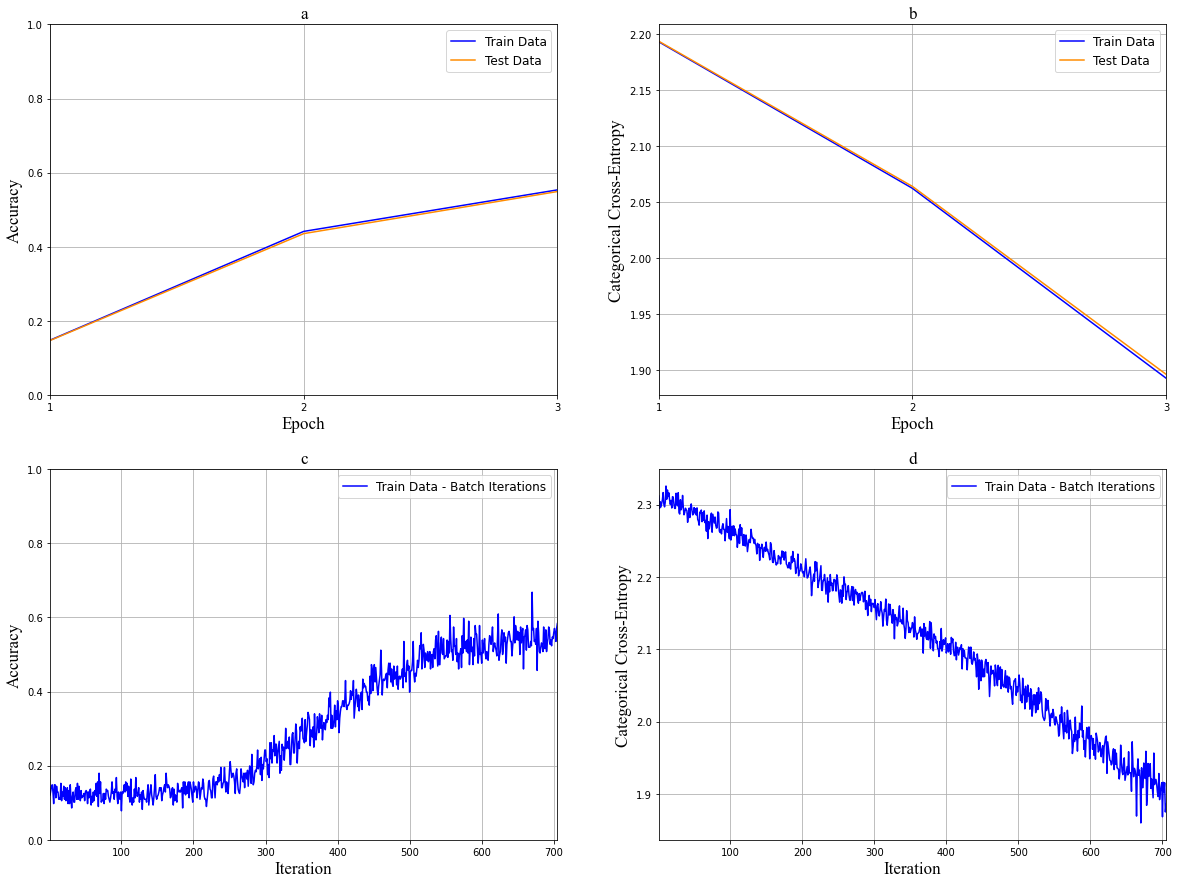

In [18]:
learning_rate = 1e-3
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train Data')
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test Data')
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train Data')
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test Data')
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 2:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical-cross entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical-cross entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$.

<a name="q112"></a>

#### Task 1.1.2 [^](#outline)

For the first task we train the MLP on batches of $256$ data-points for $40$ epochs, but this time using learning rates of $10^{-5}$ and $10^{-1}$. First we train the MLP model using a learning rate of $10^{-5}$ shown below.

In [ ]:
# determining the hyper-parameters
learning_rate = 1e-5
batch_size = 256
epochs = 40

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)

Next we train the MLP model using a learning rate of $10^{-1}$ shown below.

In [ ]:
# determining the hyper-parameters
learning_rate = 1e-1
batch_size = 256
epochs = 40

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)

Next we plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-5}$, for both the training and the test data, as shown in *Figure 3*.

In [ ]:
learning_rate = 1e-5
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train Data')
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test Data')
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train Data')
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test Data')
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 3:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical-cross entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical-cross entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-5}$.

Next we plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-1}$, for both the training and the test data, as shown in *Figure 4*.

In [ ]:
learning_rate = 1e-1
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train Data')
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test Data')
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train Data')
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test Data')
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 4:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical-cross entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical-cross entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-1}$.

As we can see from *Figure 3* and *Figure 4*.

<a name="q113"></a>

#### Task 1.1.3 [^](#outline)

Finally, for this task, we train the MLP for $80$ epochs, using batches of $256$ data-points and a learning rate of $10^{-3}$.

In [ ]:
# determining the hyper-parameters
learning_rate = 1e-3
batch_size = 256
epochs = 80

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)

Next we plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=80$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$, for both the training and the test data, as shown in *Figure 5*.

In [ ]:
learning_rate = 1e-3
batch_size = 256
epochs = 80

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train Data')
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test Data')
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train Data')
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test Data')
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 5:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical-cross entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical-cross entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=80$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$.

As we can see f

<a name="q12"></a>
## 1.2 Convolutional Neural Network (CNN) [^](#outline)

<a name="task-2"></a>

# Task 2: Unsupervised Learning [^](#outline)

<a name="q21"></a>

## 2.1 Dimensionality Reduction and Clustering of a Subset of the Fashion-MNIST Image Data [^](#outline)

<a name="q22"></a>

## 2.2 Clustering of the Feature Matrix [^](#outline)

<a name="q23"></a>

## 2.3 Graph-Based Analysis [^](#outline)

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

<a name="q31"></a>

## 3.1 Non-Negative Matrix Factorization (NMF) for Dimensionality Reduction [^](#outline)

<a name="q32"></a>

## 3.2 Community Detection [^](#outline)